In [ ]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# pip install plot-keras-history
# https://pypi.org/project/plot-keras-history/
from plot_keras_history import show_history, plot_history

# Import our dataset
#loan_df = pd.read_csv('Data_Source/loan.csv')              # <-- original dataset with excess columns and dates from 2015-2018
loan_df = pd.read_csv('Data_Source/LC_loans_2017-2018.csv') # <-- trimmed dataset with data exclusively from 2017 and 2018 - the most recent years available

#loan_df.head()

In [2]:
# round interest rate to whole number to measure accuracy to the nearest 0.5%
    # has been tested, with no real improvement because of the scale of the dataset

# loan_df_interest_rounded = list(loan_df['int_rate'])
# interest_rounded_list = []

# for number in loan_df_interest_rounded:
#     interest_rounded_list.append(round(number * 2) / 2)

# loan_df['interest_rounded'] = interest_rounded_list

# Predicting Grade or Sub Grade

In [3]:
# split into labels and features

y = loan_df['grade']           # use either grade or sub_grade
#y = loan_df['sub_grade']

# in X, *always* keep 'annual_inc', 'dti', 'loan_amnt', 'term' - thanks Jerry!
X = loan_df[['home_ownership', 'annual_inc', 'loan_amnt', 'term', 'dti', 'open_acc',
             'pub_rec', 'loan_status', 'revol_util', 'acc_now_delinq']] # 'revol_util', 'acc_now_delinq'

# removed ['mort_acc', 'emp_length', 'tot_cur_bal'] to work with the trimmed data file

# can also try:
# 'employment_length'
# 'title'
# 'pub_rec_bankruptcies'
# 'tot_cur_bal'
# 'loan_status'

In [4]:
# find rows with null values in specific columns
#X.query('annual_inc != annual_inc') # 'column_name != column_name' shows where NaNs exist

In [5]:
# drop the 4 nulls from annual_inc
#X = X.drop(index=[2141934, 2141935, 2141965, 2142018])
#y = y.drop(index=[2141934, 2141935, 2141965, 2142018])

    # this and previous cell updated to use for loop below

In [6]:
# drop rows with null values in any column - will be around 2000 rows

# get column names from X
column_names = X.columns

# loop through X to drop the rows that have nulls and apply the same drops to y
for column in column_names:
    # temp list to hold index values that have nulls in each column
    null_list = list(X.query(f'{column} != {column}').index)
    # drop from X
    X = X.dropna(axis='index', subset=[f'{column}'])
    # drop from y
    y = y.drop(index=null_list)

In [7]:
# # drop nulls - not all columns have nulls so these are the ones that do
# dti_null_list = list(X.query('dti != dti').index)
# X = X.dropna(axis='index', subset=['dti'])
# y = y.drop(index=dti_null_list)

# emp_length_null_list = list(X.query('emp_length != emp_length').index)
# X = X.dropna(axis='index', subset=['emp_length'])
# y = y.drop(index=emp_length_null_list)

    # updated to for loop above

In [8]:
# fillna with 0 (should only impact 'mths_since_last_delinq', leading to higher accuracy. nulls in this column hurt the accuracy a lot)
# this step needs to be done after any other dropnas
#X = X.fillna(0)

    # not necessary without this column currently

In [9]:
y = pd.get_dummies(y) # get_dummies on y is required when predicting grades or subgrades

In [10]:
# setting dtype to float may not be necessary. Without this, default for many columns is boolean
X = pd.get_dummies(X) #dtype=float
#X.head()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) # stratify=y, test_size=0.2,

In [12]:
# standardize the data

scaler = StandardScaler()

X_scaled = scaler.fit(X_train)

X_train_scaled = X_scaled.transform(X_train)
X_test_scaled = X_scaled.transform(X_test)

In [13]:
# create layers for the neural network model. Number of layers is subjective and should be tested with more/fewer layers and nodes.

grade_model = tf.keras.models.Sequential()
grade_model.add(tf.keras.layers.Dense(units=500, input_dim=21, activation='sigmoid'))
grade_model.add(tf.keras.layers.Dense(units=250, activation='sigmoid'))
#grade_model.add(tf.keras.layers.Dense(units=125, activation='sigmoid'))
grade_model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

In [14]:
# # lower the learning rate to prevent overfitting. overfitting was common at the default learning rate, causing accuracy to tank within 1 epoch
# learning_rate = tf.Variable(0.0001, trainable=True)
# tf.keras.backend.set_value(learning_rate, 0.0001)

    # unnecessary because adam has a built in learning rate modifier

In [15]:
# train the model and check accuracy

grade_model.compile(loss='categorical_focal_crossentropy', optimizer='adam', metrics=['accuracy'])

fit_grade_model = grade_model.fit(X_train_scaled, y_train, epochs=5)


Epoch 1/5


21941/21941 [==============================] - 36s 2ms/step - loss: 0.2006 - accuracy: 0.4140
Epoch 2/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1972 - accuracy: 0.4200
Epoch 3/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1961 - accuracy: 0.4217
Epoch 4/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1955 - accuracy: 0.4230
Epoch 5/5
21941/21941 [==============================] - 35s 2ms/step - loss: 0.1950 - accuracy: 0.4240


In [16]:
# export model to keras file
    # using keras over hdf5 because hdf5 is now legacy
grade_model.save('grade_model.keras')

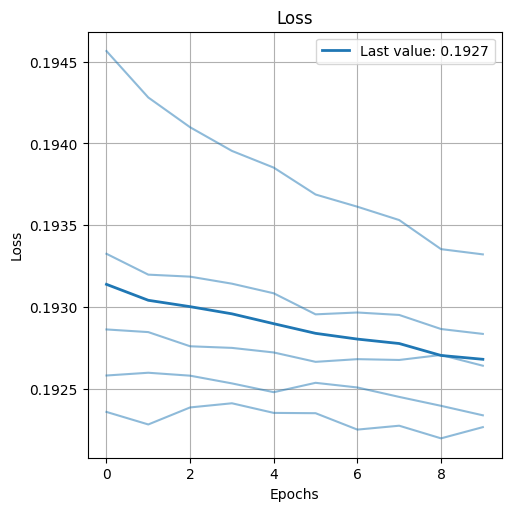

In [17]:
grade_histories = []
for holdout in range(5):
    model = grade_model
    grade_histories.append(model.fit(X_train_scaled, y_train, epochs=10, verbose=0))

plot_history(
    grade_histories,
    path='grade_plots',
    single_graphs=True,
    show_standard_deviation=False,
    show_average=True
)

plt.close()

# Predicting Interest Rate

In [18]:
y = loan_df[['int_rate']] # in double brackets for y scaling testing
# X = loan_df[['home_ownership', 'annual_inc', 'loan_amnt', 'term', 'dti', 'mort_acc', 'open_acc',
#              'emp_length', 'tot_cur_bal', 'revol_util', 'acc_now_delinq']]

X = loan_df[['annual_inc', 'dti', 'loan_amnt', 'term', 'sub_grade', 'revol_util', 'acc_now_delinq', 'loan_status', 
            'pub_rec_bankruptcies', 'purpose', 'home_ownership']]

# ['emp_length', 'total_il_high_credit_limit', 'tot_cur_bal', 'mort_acc', 'num_accts_ever_120_pd', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim']
    # temporarily removed for testing cleaned dataset

In [19]:
# drop rows with null values in any column - will be around 2000 rows

# get column names from X
column_names = X.columns

# loop through X to drop the rows that have nulls and apply the same drops to y
for column in column_names:
    # temp list to hold index values that have nulls in each column
    null_list = list(X.query(f'{column} != {column}').index)
    # drop from X
    X = X.dropna(axis='index', subset=[f'{column}'])
    # drop from y
    y = y.drop(index=null_list)

In [20]:
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# standardize the data

scaler = StandardScaler()

X_scaled = scaler.fit(X_train)

X_train_scaled = X_scaled.transform(X_train)
X_test_scaled = X_scaled.transform(X_test)

# testing scaling y
y_scaled = scaler.fit(y_train)
y_train_scaled = y_scaled.transform(y_train)
y_test_scaled = y_scaled.transform(y_test)

In [22]:
interest_model = tf.keras.models.Sequential()
interest_model.add(tf.keras.layers.Dense(units=50, input_dim=69, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=25, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=12, activation='sigmoid'))
interest_model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [23]:
# train the model and check accuracy
interest_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['R2Score'])

fit_interest_model = interest_model.fit(X_train_scaled, y_train_scaled, epochs=5)

Epoch 1/5
21941/21941 [==============================] - 22s 957us/step - loss: 0.0146 - r2_score: 0.9854
Epoch 2/5
21941/21941 [==============================] - 20s 922us/step - loss: 0.0066 - r2_score: 0.9934
Epoch 3/5
21941/21941 [==============================] - 20s 924us/step - loss: 0.0064 - r2_score: 0.9936
Epoch 4/5
21941/21941 [==============================] - 21s 954us/step - loss: 0.0063 - r2_score: 0.9937
Epoch 5/5
21941/21941 [==============================] - 20s 923us/step - loss: 0.0063 - r2_score: 0.9937


In [24]:
#show_history(fit_interest_model) # single_graphs=True        temporarily commented for a full run
#plt.close()

In [25]:
# export model to keras file
    # using keras over hdf5 because hdf5 is now legacy
interest_model.save('interest_model.keras')

In [26]:
interest_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                3500      
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 12)                312       
                                                                 
 dense_6 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5100 (19.92 KB)
Trainable params: 5100 (19.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


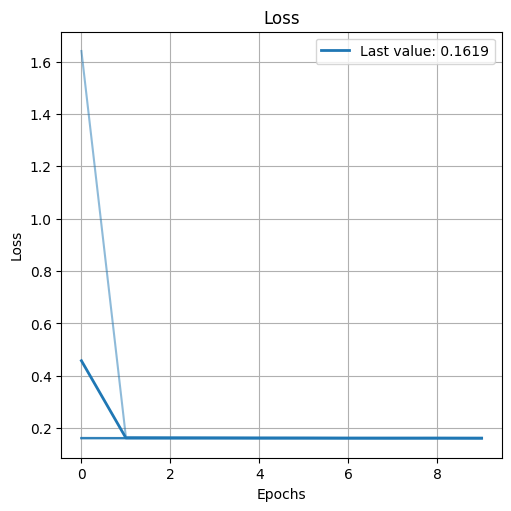

In [27]:
interest_histories = []
for holdout in range(5):
    model = interest_model
    interest_histories.append(model.fit(X_train_scaled, y_train, epochs=10, verbose=0))

plot_history(
    interest_histories,
    path='interest_plots',
    single_graphs=True,
    show_standard_deviation=False,
    show_average=True
)

plt.close()